In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import softmax
import collections

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
import xgboost as xgb

from FairReg import FairReg
from unfairness_measures import DP_unfairness, probabilistic_pred_unfairness
from plots import plot_distributions_compare, plot_predictions_compare, plot_distributions, plot_predictions

### Data preprocessing

In [2]:
df = pd.read_csv('./data/communities.csv')
df = df.fillna(0)

sens_attrs = ['racepctblack', 'racePctWhite', 'racePctAsian', 'racePctHisp']
df['race'] = df[sens_attrs].idxmax(axis=1) #creating a new column based on ethnicity
df = df.drop(columns=sens_attrs)

df = df.drop(df[df['ViolentCrimesPerPop']==0].index)
y = df['ViolentCrimesPerPop'] #target
df = df.drop('ViolentCrimesPerPop', axis=1)

mapping = {'racePctWhite':1, 'racepctblack':0, 'racePctAsian':0, 'racePctHisp':0}

S = df['race'].map(mapping) #sensitive attribute
df = df.drop('race', axis=1)

X = df.to_numpy() #features

In [3]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# y = y.to_numpy()
# scaler.fit(y.reshape(-1, 1))
# y = scaler.transform(y.reshape(-1, 1))
# y = y.reshape(1,-1)[0]

In [4]:
#getting the frequencies of the sensitive values

p_0 = S.value_counts(1)[0] #non-white
p_1 = S.value_counts(1)[1] #white

Splitting data into **train**, **unlab** and **test** groups

In [5]:
TRAIN_SIZE, UNLAB_SIZE, TEST_SIZE = 0.4, 0.4, 0.2

X_train, X_, S_train, S_, y_train, y_ = train_test_split(X, S, y, train_size = TRAIN_SIZE, stratify = S)
X_unlab, X_test, S_unlab, S_test, y_unlab, y_test = train_test_split(X_, S_, y_, test_size = TEST_SIZE/(1-TRAIN_SIZE), stratify = S_)

Training the **base (unfair) regression** method to predict **y** given **X**

In [6]:
reg = LinearRegression(fit_intercept=False)
reg.fit(X_train,y_train)

LinearRegression(fit_intercept=False)

Training a **classifier** to predict **S** given **X**

In [8]:
clf = LogisticRegression()
clf.fit(X_train, S_train)

LogisticRegression()

Training the **fair regression** to predict **y** given **X**

In [10]:
fair_reg = FairReg(reg, clf, B=1, K=2,  p=[p_0, p_1], eps=[0.0001, 0.0001], T=9000)
fair_reg.fit(X_unlab)

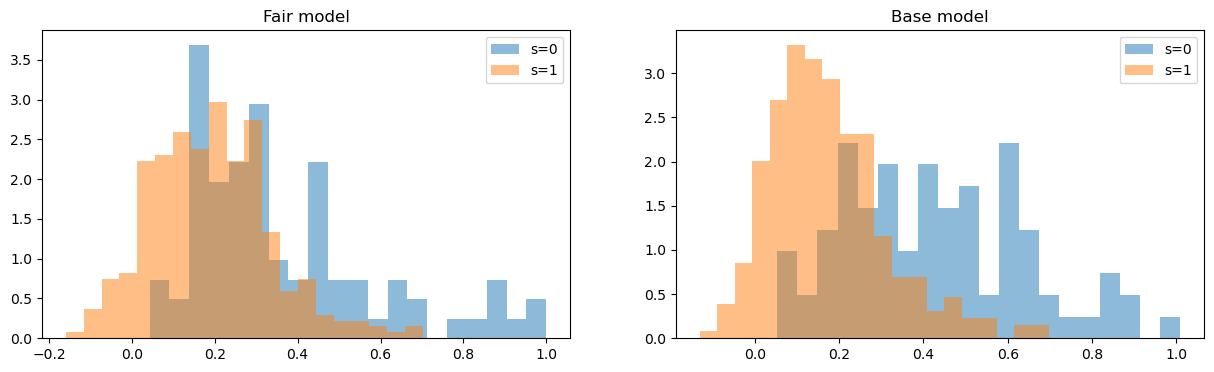

In [11]:
plot_distributions_compare(fair_reg, reg, X_test, S_test)

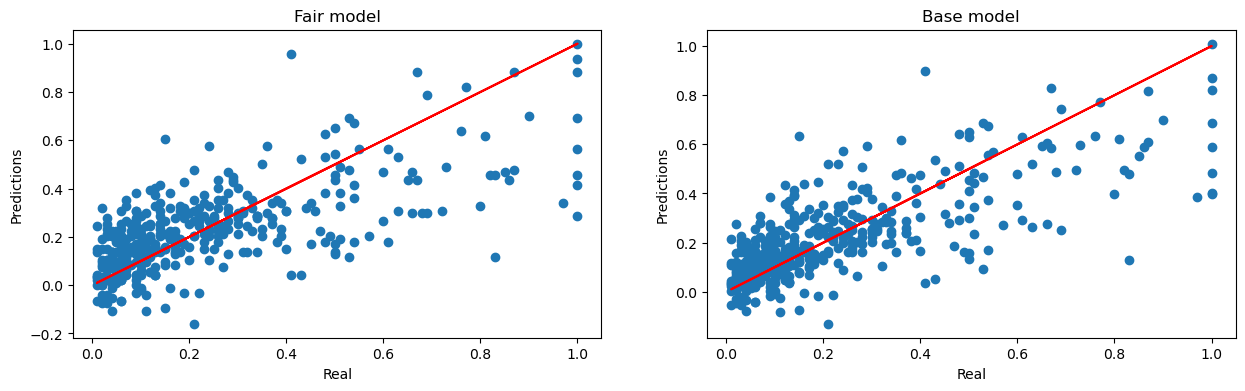

In [12]:
plot_predictions_compare(fair_reg, reg, X_test, y_test)

### Unfairness in the grid

In [14]:
unf = probabilistic_pred_unfairness(fair_reg, X_test, S_test)
print("For our notion of fairness (in the grid)")
print("============================================================")
for key, value in unf.items():
    print("sum unfairness for s="+str(key)+" is "+str(sum(value)))
    print("max unfairness for s="+str(key)+" is "+str(max(value)))
    print("average unfairness for s="+str(key)+" is "+str(value.mean()))
    print("============================================================")

For our notion of fairness (in the grid)
sum unfairness for s=0 is 0.37197685680194303
max unfairness for s=0 is 0.004509846336857682
average unfairness for s=0 is 0.0019681315174705973
sum unfairness for s=1 is 0.10101607932321131
max unfairness for s=1 is 0.0012247186537792387
average unfairness for s=1 is 0.0005344766101757211


### DP-unfairness

In [15]:
bins = fair_reg.Q_L

##### For fair predictor

In [16]:
y_test_pred_fair = fair_reg.predict(X_test)
DP_unfairness(y_test_pred_fair, S_test, bins=bins)

{0: 0.2534141294708839, 1: 0.06881853356238055}

In [17]:
print("The MSE risk of the fair predictor is "+str(mse(y_test, y_test_pred_fair)))

The MSE risk of the fair predictor is 0.02828325466171965


##### For base predictor


In [18]:
y_test_pred_base = reg.predict(X_test)
DP_unfairness(y_test_pred_base, S_test, bins=bins)

{0: 0.4346887369557394, 1: 0.11665768020537393}

In [19]:
print("The MSE risk of the base predictor is "+str(mse(y_test, y_test_pred_base)))

The MSE risk of the base predictor is 0.023857223128008757


##### In the test data

In [20]:
DP_unfairness(y_test, S_test, bins=bins)

{0: 0.3794856636121785, 1: 0.1030552121630518}